NBA Analysis
Analyzes advanced statistics, creates a regression model to predict salary, and offers preliminary assessment of under-and-over-valued players based on actual salaries relative to the predicted salaries 

In [57]:
#1 Import libraries
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [58]:
# load csv files
# Note: Full script (available in Github repo) scrapes (i) advanced stats and (ii) salary data from Basketballreference.com 
# and puts them into two separate csv files.
# This summary analysis uploads the two csv files as the starting point
df_stats = pd.read_csv('nba_advanced_stats_2025.csv')
df_salary = pd.read_csv('nba_player_salaries_2025.csv')

In [59]:
# Explore data
print(df_stats.shape, df_salary.shape)

(736, 29) (470, 2)


In [60]:
# Clean the salary data sets 

# check for missing values
print(df_salary.isnull().sum())

# clean up salary data
# Clean salary data
df_salary_updated = df_salary.dropna(subset=['Salary_2025_26']).drop_duplicates(subset=['Player'], keep='first').reset_index(drop=True)

# check
print(f"Duplicate players in salary data: {df_salary_updated['Player'].duplicated().sum()}")


Player             0
Salary_2025_26    22
dtype: int64
Duplicate players in salary data: 0


In [61]:
# clean the stats data set

# check for duplicates in Player names
print(f"Duplicate players in stats data: {df_stats['Player'].duplicated().sum()}")

# identify players who appear multiple times
player_counts = df_stats['Player'].value_counts()
print(player_counts)
duplicated_players = player_counts[player_counts > 1].index
print(duplicated_players)

# if players have multile entries, keep the instance with 2TM or 3TM, otherwise keep the first occurrence
def keep_combined_stats(group):
    # check if there's a 2TM or 3TM entry
    combined_entry = group[group['Team'].isin(['2TM', '3TM'])]
    if len(combined_entry) > 0:
        return combined_entry
    else:
        # if no combined entry, return the original entry 
        return group 
    
# apply the function to each group of duplicated players
df_stats_cleaned = df_stats.groupby('Player', group_keys=False).apply(keep_combined_stats)

# reset index after groupby operation
df_stats_cleaned = df_stats_cleaned.reset_index(drop=True)

Duplicate players in stats data: 166
Player
Dennis Schröder     4
Colin Castleton     4
David Roddy         4
MarJon Beauchamp    4
Cody Martin         3
                   ..
James Wiseman       1
Alondes Williams    1
Zyon Pullin         1
Jahlil Okafor       1
Jayson Tatum        1
Name: count, Length: 570, dtype: int64
Index(['Dennis Schröder', 'Colin Castleton', 'David Roddy', 'MarJon Beauchamp',
       'Cody Martin', 'Kyle Kuzma', 'Zach Collins', 'Jake LaRavia',
       'Jonas Valančiūnas', 'Bogdan Bogdanović', 'Luka Dončić', 'Terance Mann',
       'Javonte Green', 'Nick Richards', 'Jusuf Nurkić', 'Caris LeVert',
       'Jimmy Butler', 'Kevin Porter Jr.', 'D'Angelo Russell', 'De'Aaron Fox',
       'De'Andre Hunter', 'Caleb Martin', 'Kyle Anderson', 'Ben Simmons',
       'Davion Mitchell', 'Andrew Wiggins', 'Quentin Grimes', 'Anthony Davis',
       'KJ Martin', 'Georges Niang', 'Thomas Bryant', 'Bruce Brown',
       'Kevin Huerter', 'Dorian Finney-Smith', 'Tre Jones', 'Kelly Olynyk

C:\Users\elder\AppData\Local\Temp\ipykernel_20320\1444079688.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_stats_cleaned = df_stats.groupby('Player', group_keys=False).apply(keep_combined_stats)


In [62]:
# check for duplicated players again
print(f"Duplicate players in cleaned stats data: {df_stats_cleaned['Player'].duplicated().sum()}")


Duplicate players in cleaned stats data: 0


In [63]:
# Merge datasets on Player name
df_merged = pd.merge(df_stats_cleaned, df_salary_updated[['Player', 'Salary_2025_26']], on='Player', how='inner')
df_merged['Salary_Millions'] = df_merged['Salary_2025_26'] / 1_000_000
print(f"Merged dataset shape: {df_merged.shape}")
print(f"Duplicate players in cleaned stats data: {df_merged['Player'].duplicated().sum()}")
print(df_merged.columns)

Merged dataset shape: (399, 31)
Duplicate players in cleaned stats data: 0
Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Awards', 'Salary_2025_26', 'Salary_Millions'],
      dtype='object')


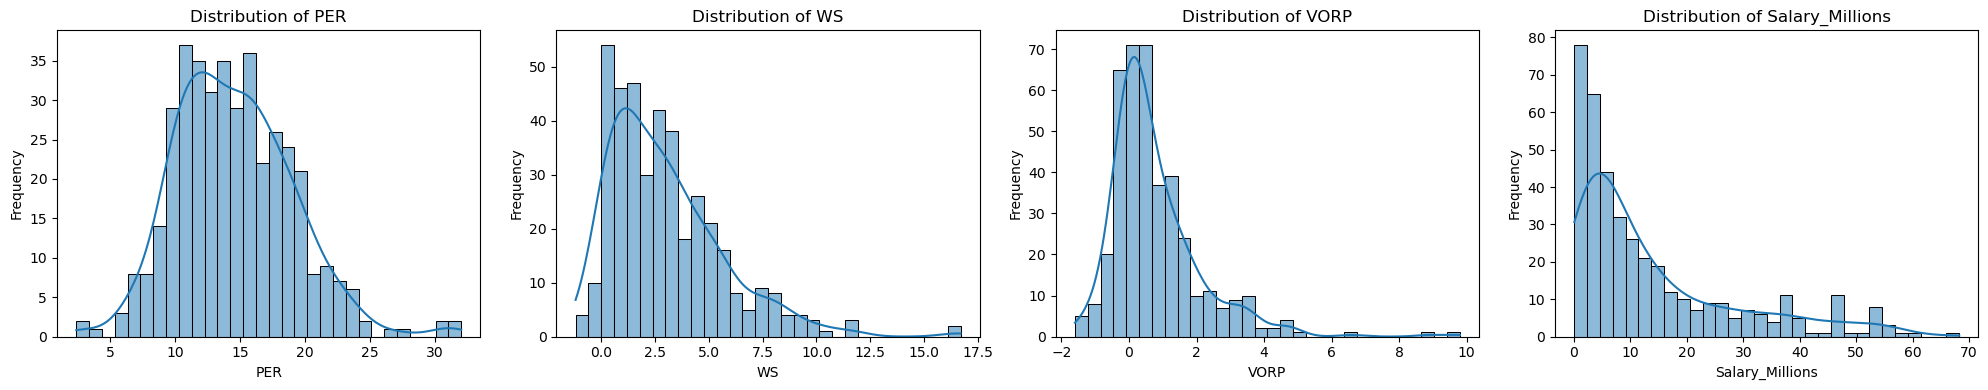

In [64]:
# Create histograms of key features
features = ['PER', 'WS', 'VORP', 'Salary_Millions']
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for idx, feature in enumerate(features):
    sns.histplot(df_merged[feature], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

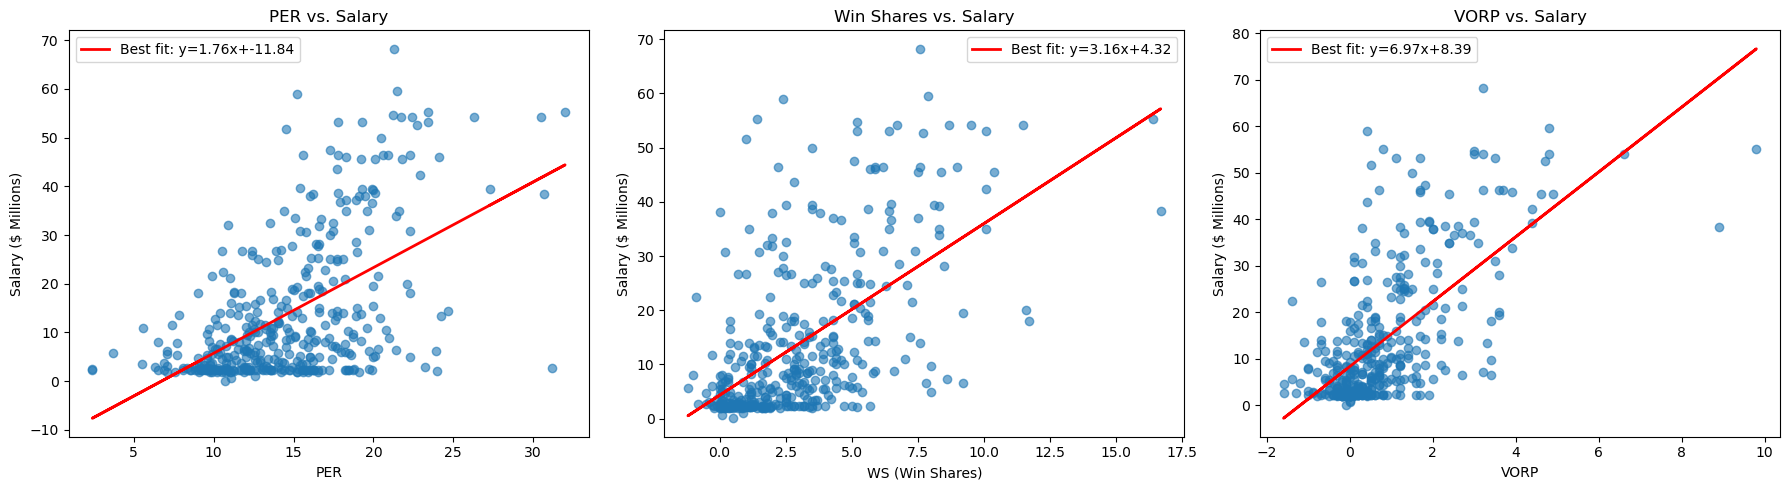

In [65]:
# scatter plot of PER, WS and VORP vs. Salary with best fit lines 

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Function to add best fit line
def add_best_fit(ax, x, y):
    # Remove any NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Calculate best fit line
    z = np.polyfit(x_clean, y_clean, 1)
    p = np.poly1d(z)
    
    # Add line to plot
    ax.plot(x_clean, p(x_clean), "r-", linewidth=2, label=f'Best fit: y={z[0]:.2f}x+{z[1]:.2f}')
    ax.legend()

# Scatter plot 1: PER vs. Salary
axes[0].scatter(df_merged['PER'], df_merged['Salary_Millions'], alpha=0.6)
add_best_fit(axes[0], df_merged['PER'].values, df_merged['Salary_Millions'].values)
axes[0].set_xlabel('PER')
axes[0].set_ylabel('Salary ($ Millions)')
axes[0].set_title('PER vs. Salary')

# Scatter plot 2: WS vs. Salary
axes[1].scatter(df_merged['WS'], df_merged['Salary_Millions'], alpha=0.6)
add_best_fit(axes[1], df_merged['WS'].values, df_merged['Salary_Millions'].values)
axes[1].set_xlabel('WS (Win Shares)')
axes[1].set_ylabel('Salary ($ Millions)')
axes[1].set_title('Win Shares vs. Salary')

# Scatter plot 3: VORP vs. Salary
axes[2].scatter(df_merged['VORP'], df_merged['Salary_Millions'], alpha=0.6)
add_best_fit(axes[2], df_merged['VORP'].values, df_merged['Salary_Millions'].values)
axes[2].set_xlabel('VORP')
axes[2].set_ylabel('Salary ($ Millions)')
axes[2].set_title('VORP vs. Salary')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

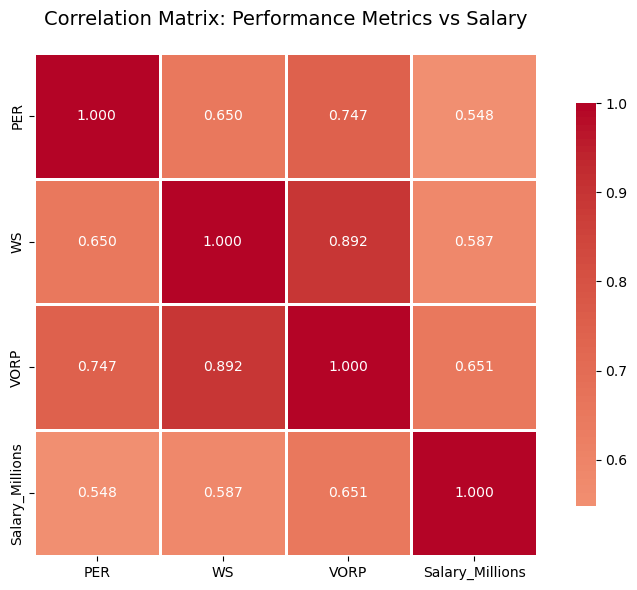

In [66]:
# Create correlation matrix for PER, WS, VORP, and Salary
correlation_matrix = df_merged[['PER', 'WS', 'VORP', 'Salary_Millions']].corr()

# Create a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            fmt='.3f',   # Format to 3 decimal places
            cmap='coolwarm',  # Color scheme
            center=0,    # Center colormap at 0
            square=True,  # Make cells square
            linewidths=1,  # Add gridlines
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Performance Metrics vs Salary', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


Training Set:
  R² Score: 0.6448
  RMSE: $8.44M
  MAE: $6.35M

Test Set:
  R² Score: 0.5303
  RMSE: $10.62M
  MAE: $8.20M


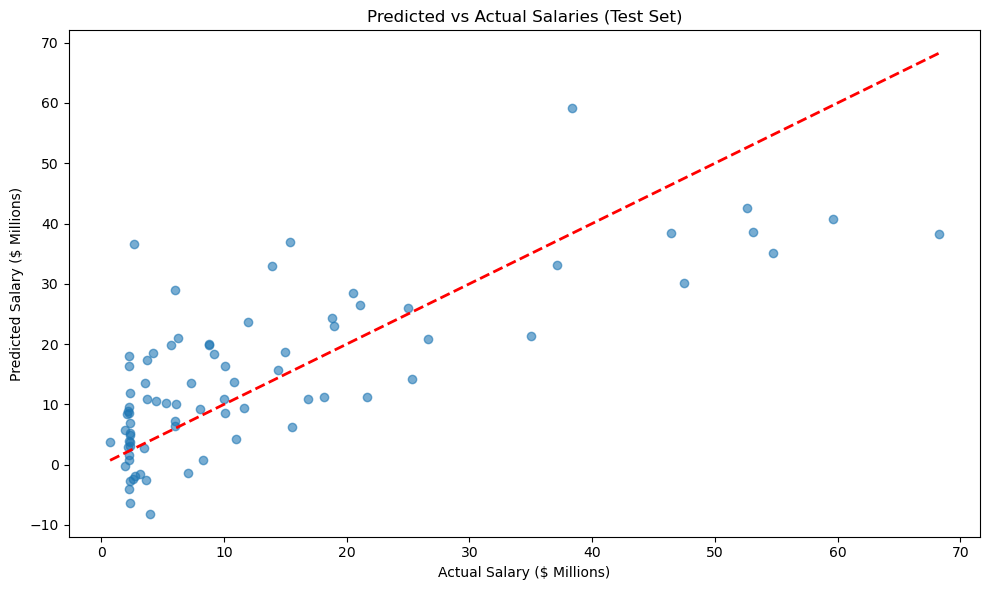

In [67]:
# create a multi-linear regression analysis to predict salaries

# Select features for the model (all numeric columns except salary columns)
features_to_use = ['PER', 'TS%', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 
                   'MP', 'G', 'USG%', 'AST%', 'TRB%']

# Remove rows with missing values in the features we're using
df_model = df_merged[features_to_use + ['Salary_Millions']].dropna()

# Separate features (X) and target variable (y)
X = df_model[features_to_use]
y = df_model['Salary_Millions']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
print(f"\nTraining Set:")
print(f"  R² Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}M")
print(f"  MAE: ${mean_absolute_error(y_train, y_pred_train):.2f}M")

print(f"\nTest Set:")
print(f"  R² Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}M")
print(f"  MAE: ${mean_absolute_error(y_test, y_pred_test):.2f}M")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salary ($ Millions)')
plt.ylabel('Predicted Salary ($ Millions)')
plt.title('Predicted vs Actual Salaries (Test Set)')
plt.tight_layout()
plt.show()

In [68]:
# Create a dataframe with actual vs predicted salaries
# Get the player names and age from the original df_merged using the index
player_names = df_merged.loc[X_test.index, 'Player']
player_ages = df_merged.loc[X_test.index, 'Age']

results_df = pd.DataFrame({
    'Player': player_names.values,
    'Age': player_ages.values,
    'Actual_Salary_Millions': y_test.values,
    'Predicted_Salary_Millions': y_pred_test,
    'Difference_Millions': y_test.values - y_pred_test
})

# Sort by difference to identify overpaid and underpaid players
results_df = results_df.sort_values('Difference_Millions', ascending=False)

print("==" * 40)
print("TOP 3 OVERPAID PLAYERS (Actual > Predicted)")
print("==" * 40)
print(results_df.head(3)[['Player', 'Age', 'Actual_Salary_Millions', 
                          'Predicted_Salary_Millions', 'Difference_Millions']].to_string(index=False))

print("\n" + "==" * 40)
print("TOP 3 UNDERPAID PLAYERS (Predicted > Actual)")
print("==" * 40)
print(results_df.tail(3)[['Player', 'Age', 'Actual_Salary_Millions', 
                          'Predicted_Salary_Millions', 'Difference_Millions']].to_string(index=False))

# Optionally save to CSV
results_df.to_csv('salary_predictions.csv', index=False)
print("\nFull results saved to 'salary_predictions.csv'")

TOP 3 OVERPAID PLAYERS (Actual > Predicted)
        Player  Age  Actual_Salary_Millions  Predicted_Salary_Millions  Difference_Millions
Damian Lillard 34.0               68.230450                  38.271098            29.959352
  Kevin Durant 36.0               54.708609                  35.042569            19.666040
 Stephen Curry 36.0               59.606817                  40.694868            18.911949

TOP 3 UNDERPAID PLAYERS (Predicted > Actual)
        Player  Age  Actual_Salary_Millions  Predicted_Salary_Millions  Difference_Millions
Paolo Banchero 22.0               15.334769                  36.970741           -21.635972
    Cam Thomas 23.0                5.993172                  28.962163           -22.968991
 James Wiseman 23.0                2.667947                  36.588202           -33.920255

Full results saved to 'salary_predictions.csv'
